# DSC Workshop: Object Detection
### Joshua S Raju

---

## Dependencies

In [60]:
!nvidia-smi

Sat Feb 22 17:13:46 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 560.35.03              Driver Version: 560.35.03      CUDA Version: 12.6     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla P100-PCIE-16GB           Off |   00000000:00:04.0 Off |                    0 |
| N/A   35C    P0             31W /  250W |     619MiB /  16384MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [61]:
!pip install ultralytics roboflow

In [62]:
import cv2
import matplotlib.pylab as plt

import os 

from sklearn.metrics.pairwise import cosine_similarity

from ultralytics import YOLO

import tensorflow as tf
import torch

# Understanding the Model

In [63]:
# Loading the model
model = YOLO('yolo11n.pt')

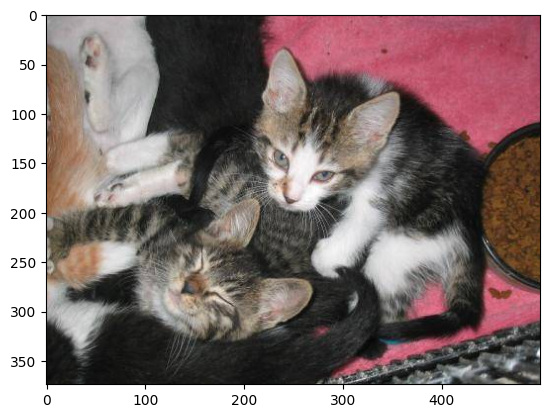

In [64]:
# Test Img
img_path = '/kaggle/input/cat-and-dog/training_set/training_set/cats/cat.1025.jpg'
img = cv2.cvtColor(cv2.imread(img_path), cv2.COLOR_BGR2RGB)
plt.imshow(img)


0: 480x640 3 cats, 1 bowl, 12.5ms
Speed: 2.4ms preprocess, 12.5ms inference, 1.7ms postprocess per image at shape (1, 3, 480, 640)


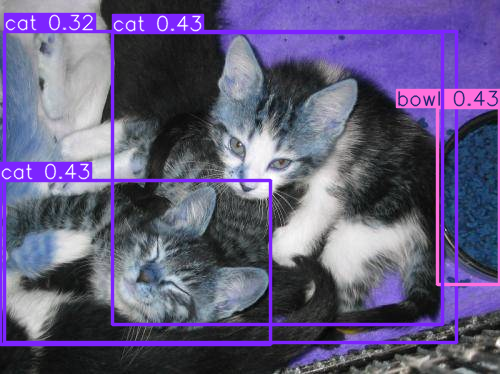

In [65]:
# Predicting Img
results = model.predict(img)
results[0].show()

In [66]:
model.names

{0: 'person',
 1: 'bicycle',
 2: 'car',
 3: 'motorcycle',
 4: 'airplane',
 5: 'bus',
 6: 'train',
 7: 'truck',
 8: 'boat',
 9: 'traffic light',
 10: 'fire hydrant',
 11: 'stop sign',
 12: 'parking meter',
 13: 'bench',
 14: 'bird',
 15: 'cat',
 16: 'dog',
 17: 'horse',
 18: 'sheep',
 19: 'cow',
 20: 'elephant',
 21: 'bear',
 22: 'zebra',
 23: 'giraffe',
 24: 'backpack',
 25: 'umbrella',
 26: 'handbag',
 27: 'tie',
 28: 'suitcase',
 29: 'frisbee',
 30: 'skis',
 31: 'snowboard',
 32: 'sports ball',
 33: 'kite',
 34: 'baseball bat',
 35: 'baseball glove',
 36: 'skateboard',
 37: 'surfboard',
 38: 'tennis racket',
 39: 'bottle',
 40: 'wine glass',
 41: 'cup',
 42: 'fork',
 43: 'knife',
 44: 'spoon',
 45: 'bowl',
 46: 'banana',
 47: 'apple',
 48: 'sandwich',
 49: 'orange',
 50: 'broccoli',
 51: 'carrot',
 52: 'hot dog',
 53: 'pizza',
 54: 'donut',
 55: 'cake',
 56: 'chair',
 57: 'couch',
 58: 'potted plant',
 59: 'bed',
 60: 'dining table',
 61: 'toilet',
 62: 'tv',
 63: 'laptop',
 64: 'mou

tensor(15., device='cuda:0')
tensor([5.3549e-02, 1.8051e+02, 2.7061e+02, 3.4415e+02], device='cuda:0')
tensor(15., device='cuda:0')
tensor(45., device='cuda:0')
tensor(15., device='cuda:0')


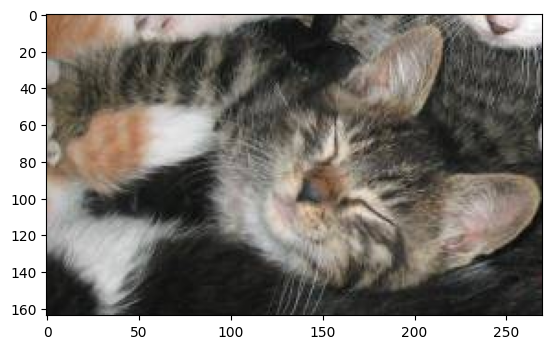

In [67]:
# Understanding the output
for result in results:
    boxes = result.boxes.xyxy
    conf = result.boxes.conf
    cls = result.boxes.cls
    for i in range(len(boxes)):
        print(cls[i])
        if conf[i] > 0.434:
            print(boxes[i])
            x1, y1, x2, y2 = map(int, boxes[i])
            img_crop = img[y1:y2, x1:x2]
            plt.imshow(img_crop)

## Model Backbone
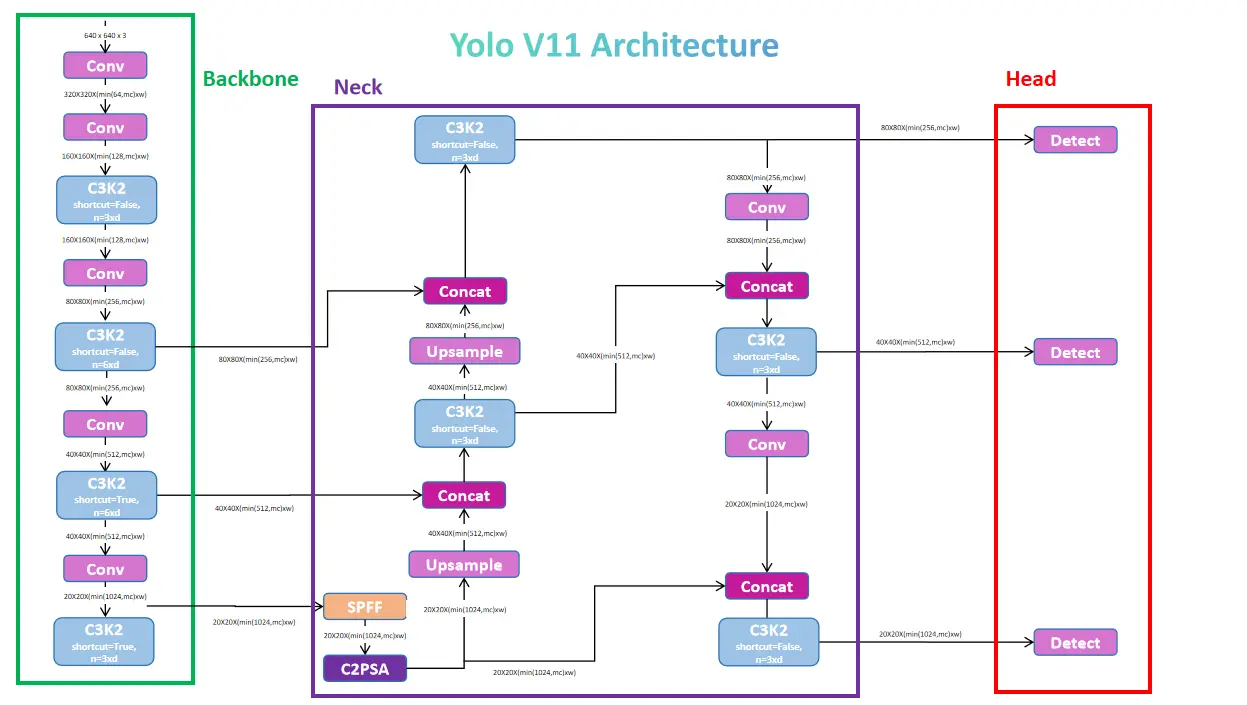
Low-Level Features
- Textures
- Edges
- Patterns
- Shapes
- More spatial

High-Level Features
- Semantic information - object tracking, recognition
- Less spatial

In [68]:
# Extracting the backbone
backbone = model.model.model[:10]
print(backbone)

Sequential(
  (0): Conv(
    (conv): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (act): SiLU(inplace=True)
  )
  (1): Conv(
    (conv): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (act): SiLU(inplace=True)
  )
  (2): C3k2(
    (cv1): Conv(
      (conv): Conv2d(32, 32, kernel_size=(1, 1), stride=(1, 1))
      (act): SiLU(inplace=True)
    )
    (cv2): Conv(
      (conv): Conv2d(48, 64, kernel_size=(1, 1), stride=(1, 1))
      (act): SiLU(inplace=True)
    )
    (m): ModuleList(
      (0): Bottleneck(
        (cv1): Conv(
          (conv): Conv2d(16, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (act): SiLU(inplace=True)
        )
        (cv2): Conv(
          (conv): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (act): SiLU(inplace=True)
        )
      )
    )
  )
  (3): Conv(
    (conv): Conv2d(64, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (act): SiLU(inplace=True)
  )
 

In [69]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [70]:
# Extarcting Test Img Feature Map
img_tensor = (torch.tensor(img).permute(2, 0, 1).float().unsqueeze(0)/255.0).to(device)
backbone(img_tensor)

tensor([[[[-2.6978e-01, -2.5696e-01, -2.7331e-01,  ..., -1.9444e-01, -2.2651e-01, -2.1103e-01],
          [-1.9794e-01, -1.6513e-01, -2.7693e-01,  ..., -2.3948e-01, -2.6609e-01, -1.7218e-01],
          [-1.8171e-01, -2.6244e-01, -2.7185e-01,  ..., -2.7139e-01, -2.7400e-01, -1.5748e-01],
          ...,
          [-2.3416e-01, -2.1152e-01, -1.5165e-01,  ..., -2.2113e-01, -2.0727e-01, -1.6345e-01],
          [-1.4341e-01, -2.1936e-01, -1.0931e-01,  ..., -1.8965e-01, -8.2362e-02, -8.0038e-02],
          [-2.7823e-01, -2.7637e-01, -2.5666e-01,  ..., -9.6568e-02, -7.7649e-02, -4.1870e-02]],

         [[ 1.6667e-01,  1.8470e-01,  2.1821e-01,  ..., -1.5483e-01,  1.2709e-04,  1.4544e-01],
          [ 6.7708e-02, -1.6009e-01,  1.7270e-01,  ..., -1.2680e-01, -9.8899e-02,  2.0566e-01],
          [ 1.9675e-01,  1.0329e-02,  2.8604e-01,  ..., -1.2445e-01, -1.0793e-01,  1.6405e-01],
          ...,
          [ 6.7959e-01,  6.6251e-01,  5.4847e-01,  ..., -2.6161e-01, -1.3067e-01, -1.2770e-01],
        

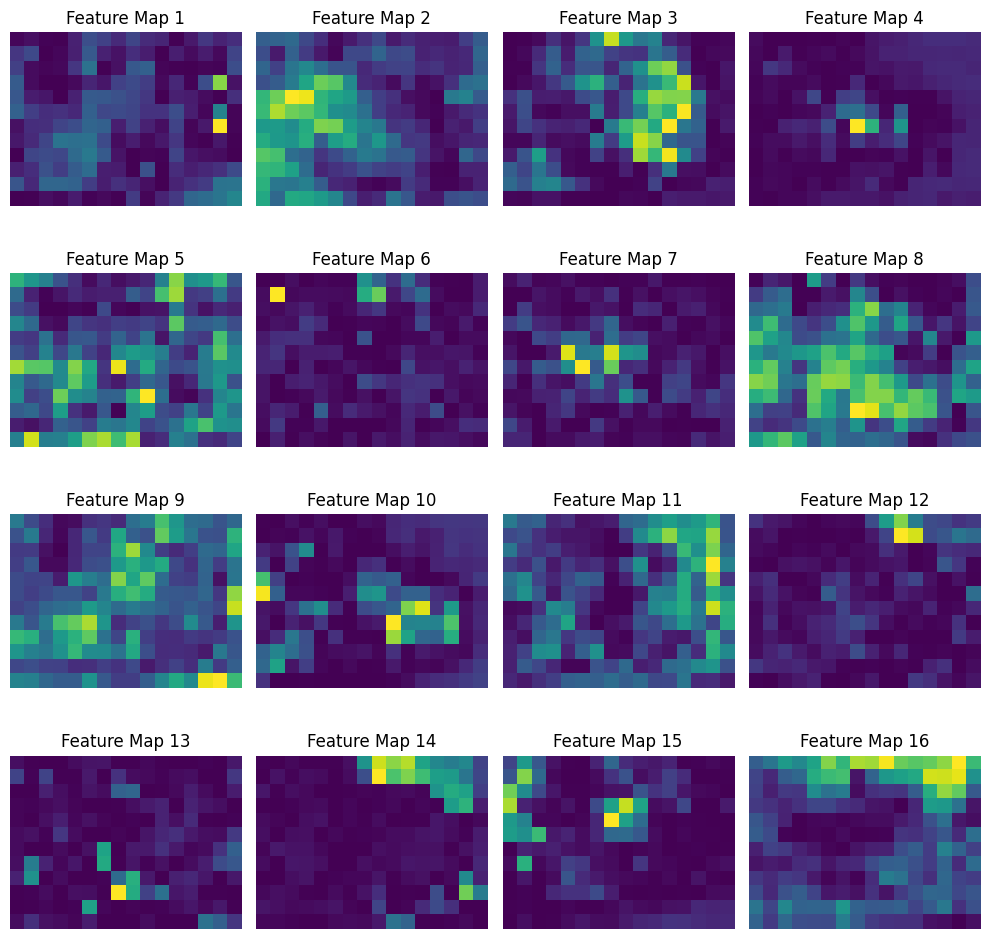

In [71]:
# Visualize the feature map
def visualize_feature_maps(feature_maps):
    """Visualize the feature maps from a CNN backbone."""
    feature_maps = feature_maps.squeeze(0)  # Remove batch dimension (1, C, H, W) -> (C, H, W)
    num_channels = feature_maps.shape[0]  # Number of feature maps

    # Plot first 16 feature maps (or fewer if not available)
    num_cols = 4
    num_rows = min(4, num_channels // num_cols + 1)

    fig, axes = plt.subplots(num_rows, num_cols, figsize=(10, 10))
    axes = axes.flatten()

    for i in range(min(num_channels, 16)):  # Limit to 16 feature maps
        ax = axes[i]
        ax.imshow(feature_maps[i].cpu().detach().numpy(), cmap='viridis')
        ax.axis("off")
        ax.set_title(f"Feature Map {i+1}")

    plt.tight_layout()
    plt.show()

visualize_feature_maps(backbone(img_tensor))

Feature Map Similarity: 0.9996


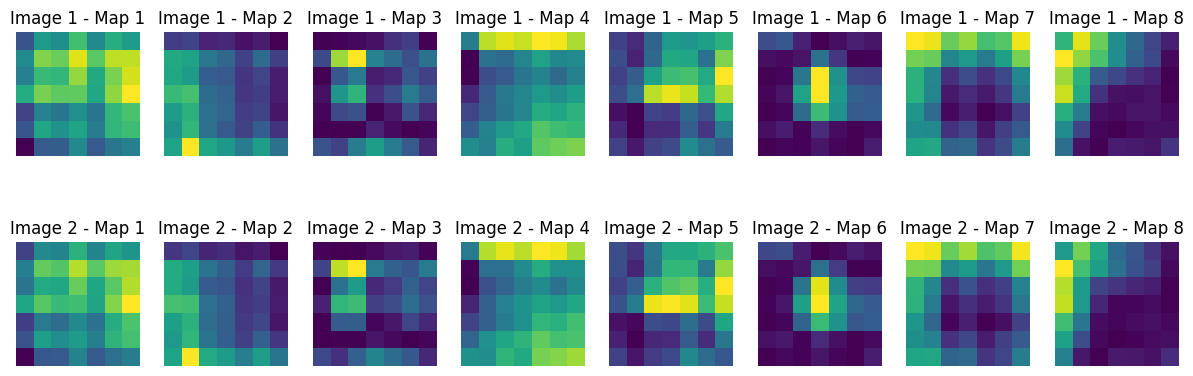

In [72]:
import cv2
import torch
import numpy as np
import matplotlib.pyplot as plt
import torch.nn.functional as F
from torchvision import transforms

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Move model to device
backbone = backbone.to(device)

# Function to resize and preprocess image (including BGR to RGB conversion)
def preprocess_image(img, target_size=(224, 224)):  
    # Convert from BGR to RGB
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    
    # Convert to PIL Image, resize, and then to Tensor
    transform = transforms.Compose([
        transforms.ToPILImage(),
        transforms.Resize(target_size),
        transforms.ToTensor(),
    ])
    
    # Convert to tensor and move to device
    img_tensor = transform(img_rgb).unsqueeze(0).float().to(device) / 255.0  # Normalize to [0, 1]
    
    return img_tensor

# Load images
img1 = cv2.imread(img_path)
img2 = cv2.imread('/kaggle/input/cat-and-dog/training_set/training_set/dogs/dog.101.jpg')

# Preprocess images
img1_tensor = preprocess_image(img1)  # First image
img2_tensor = preprocess_image(img2)  # Second image

# Pass images through the backbone to extract feature maps
feature_maps1 = backbone(img1_tensor)
feature_maps2 = backbone(img2_tensor)

# Ensure both feature maps have the same shape
assert feature_maps1.shape == feature_maps2.shape, "Feature map dimensions do not match!"

# Function to compute cosine similarity between two feature maps
def compute_similarity(fmap1, fmap2):
    fmap1 = fmap1.flatten(start_dim=1)  # Flatten each feature map to a vector
    fmap2 = fmap2.flatten(start_dim=1)
    similarity = F.cosine_similarity(fmap1, fmap2, dim=1)  # Compute cosine similarity
    return similarity.mean().item()  # Return average similarity score

# Compute similarity between the feature maps
similarity_score = compute_similarity(feature_maps1, feature_maps2)
print(f"Feature Map Similarity: {similarity_score:.4f}")

# Function to visualize feature maps
def visualize_feature_maps(fmap1, fmap2):
    fmap1 = fmap1.squeeze(0).cpu().detach().numpy()  # Remove batch dimension
    fmap2 = fmap2.squeeze(0).cpu().detach().numpy()
    
    num_feature_maps = min(8, fmap1.shape[0])  # Show up to 8 feature maps
    fig, axes = plt.subplots(2, num_feature_maps, figsize=(15, 5))

    for i in range(num_feature_maps):
        axes[0, i].imshow(fmap1[i], cmap='viridis')
        axes[0, i].axis("off")
        axes[0, i].set_title(f"Image 1 - Map {i+1}")

        axes[1, i].imshow(fmap2[i], cmap='viridis')
        axes[1, i].axis("off")
        axes[1, i].set_title(f"Image 2 - Map {i+1}")

    plt.show()

# Visualize feature maps for comparison
visualize_feature_maps(feature_maps1, feature_maps2)

## Custom Dataset

In [73]:
# Loading Dataset

from roboflow import Roboflow
rf = Roboflow(api_key="YO8Qsooc19zEzPuFRZoh")
project = rf.workspace("sunfire-marik-alar9").project("crime-cctv-object-detection")
version = project.version(8)
dataset = version.download("yolov11")
                

loading Roboflow workspace...
loading Roboflow project...



Extracting Dataset Version Zip to Crime-CCTV-Object-Detection-8 in yolov11:: 100%|██████████| 7038/7038 [00:01<00:00, 6993.70it/s]


In [74]:
# Training Model
history = model.train(data='/kaggle/working/Crime-CCTV-Object-Detection-8/data.yaml', epochs=1, imgsz='128')

Ultralytics 8.3.78 🚀 Python-3.10.12 torch-2.5.1+cu121 CUDA:0 (Tesla P100-PCIE-16GB, 16269MiB)
engine/trainer: task=detect, mode=train, model=yolo11n.pt, data=/kaggle/working/Crime-CCTV-Object-Detection-8/data.yaml, epochs=1, time=None, patience=100, batch=16, imgsz=128, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=train2, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False, sho

train: Scanning /kaggle/working/Crime-CCTV-Object-Detection-8/train/labels... 2913 images, 0 backgrounds, 0 corrupt: 100%|██████████| 2913/2913 [00:02<00:00, 1106.71it/s]


train: New cache created: /kaggle/working/Crime-CCTV-Object-Detection-8/train/labels.cache
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))


val: Scanning /kaggle/working/Crime-CCTV-Object-Detection-8/valid/labels... 400 images, 0 backgrounds, 0 corrupt: 100%|██████████| 400/400 [00:00<00:00, 773.10it/s]

val: New cache created: /kaggle/working/Crime-CCTV-Object-Detection-8/valid/labels.cache


Plotting labels to runs/detect/train2/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.001429, momentum=0.9) with parameter groups 81 weight(decay=0.0), 88 weight(decay=0.0005), 87 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 128 train, 128 val
Using 4 dataloader workers
Logging results to runs/detect/train2
Starting training for 1 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        1/1     0.422G      3.047      3.532      2.348          2        128: 100%|██████████| 183/183 [00:19<00:00,  9.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:02<00:00,  5.59it/s]


                   all        400        510       0.12      0.206     0.0889     0.0329


invalid value encountered in less
invalid value encountered in less



1 epochs completed in 0.009 hours.
Optimizer stripped from runs/detect/train2/weights/last.pt, 5.4MB
Optimizer stripped from runs/detect/train2/weights/best.pt, 5.4MB

Validating runs/detect/train2/weights/best.pt...
Ultralytics 8.3.78 🚀 Python-3.10.12 torch-2.5.1+cu121 CUDA:0 (Tesla P100-PCIE-16GB, 16269MiB)
YOLO11n summary (fused): 100 layers, 2,582,737 parameters, 0 gradients, 6.3 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:01<00:00,  6.52it/s]


                   all        400        510       0.12      0.212     0.0886     0.0328
              burglary        142        170     0.0979        0.2     0.0729     0.0249
              fighting        135        159      0.188      0.308      0.157     0.0601
               robbery        123        181     0.0742      0.127     0.0356     0.0133


invalid value encountered in less
invalid value encountered in less


Speed: 0.0ms preprocess, 1.6ms inference, 0.0ms loss, 0.8ms postprocess per image
Results saved to runs/detect/train2



image 1/1 /kaggle/working/Crime-CCTV-Object-Detection-8/train/images/ROb10_0064_jpg.rf.74558bdb832fd2b9a0f1f064b4882fe1.jpg: 128x128 (no detections), 11.5ms
Speed: 0.6ms preprocess, 11.5ms inference, 0.6ms postprocess per image at shape (1, 3, 128, 128)


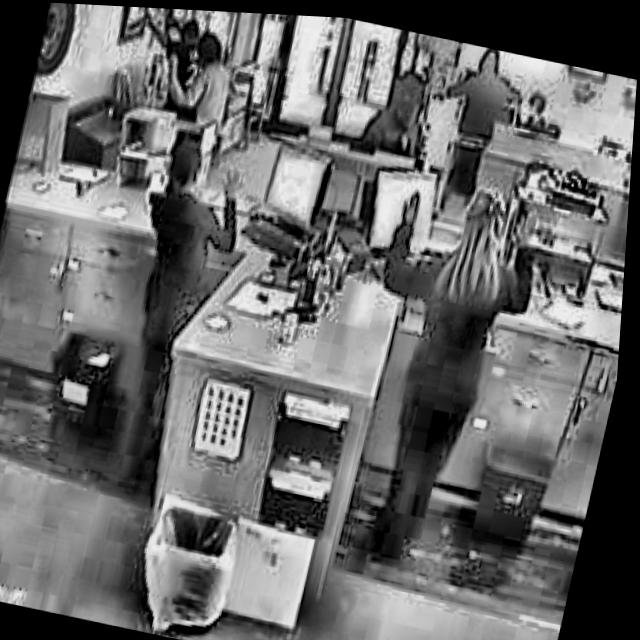

In [75]:
# Predicting Model
results = model.predict('/kaggle/working/Crime-CCTV-Object-Detection-8/train/images/ROb10_0064_jpg.rf.74558bdb832fd2b9a0f1f064b4882fe1.jpg')
results[0].show()

## Our YOLO Class

In [77]:
# Our Class
class YOLO_DSC:
    def __init__(self, model_path='yolo11n.pt', threshold = 0.434):
        self.model = YOLO(model_path)
        self.threshold = threshold
        self.backbone = self.model.model.model[:10]

    def preprocess_img(self, img_path):
        img = cv2.cvtColor(cv2.imread(img_path), cv2.COLOR_BGR2RGB)
        return img

    def get_featuremap(self, img_path):
        img = self.preprocess_img(img_path)
        results = self.model.predict(img)

        feature_maps = {}
        

        for result in results:
            boxes = result.boxes.xyxy
            conf = result.boxes.conf
            for i in range(len(boxes)):
                if conf[i] > self.threshold:
                    x1, y1, x2, y2 = map(int, boxes[i])
                    obj_crop = img[y1:y2, x1:x2]
    
                    obj_tensor = (torch.tensor(obj_crop).permute(2, 0, 1).float().unsqueeze(0)/255.0).to(device)
                    feature_maps[i] = self.backbone(obj_tensor)
        return feature_maps
        
    def train_(data, epochs, imgsz):
        history = self.model.train(data=data, epochs=epochs, imgsz=imgsz)
        return history

In [78]:
obj = YOLO_DSC()

In [79]:
obj.get_featuremap(img_path)


0: 480x640 3 cats, 1 bowl, 12.2ms
Speed: 2.4ms preprocess, 12.2ms inference, 1.5ms postprocess per image at shape (1, 3, 480, 640)


{0: tensor([[[[-0.2423, -0.2534, -0.2233,  ..., -0.1753, -0.2583, -0.1938],
           [-0.2757, -0.2615, -0.2392,  ..., -0.1759, -0.2380, -0.1883],
           [-0.2601, -0.2356, -0.1823,  ..., -0.2152, -0.2631, -0.2151],
           [-0.2637, -0.2386, -0.1774,  ..., -0.2196, -0.2535, -0.2727],
           [-0.2309, -0.2579, -0.1845,  ..., -0.2169, -0.2782, -0.2741],
           [-0.1898, -0.2531, -0.1966,  ..., -0.2355, -0.2488, -0.1813]],
 
          [[ 0.7820,  0.8527,  0.3970,  ...,  0.1815,  0.3247,  0.0644],
           [ 0.4854,  0.5805,  0.2971,  ...,  0.3340,  0.0036,  0.0188],
           [ 0.5573,  0.6076,  0.3849,  ...,  0.0924, -0.0310, -0.1659],
           [ 0.8334,  0.5030,  0.1906,  ...,  0.1006,  0.2305,  0.0685],
           [ 0.5516,  0.2925,  0.1505,  ..., -0.0978, -0.0949, -0.0454],
           [ 0.7342,  0.6466,  0.5241,  ...,  0.1091,  0.2977,  0.2201]],
 
          [[-0.2078, -0.2643, -0.2785,  ..., -0.2774, -0.2756, -0.2444],
           [-0.2678, -0.2674, -0.2655,  ..